In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns 
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier import ROCAUC

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#list_columns
train.columns

Index(['Unnamed: 0', 'NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
       'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       ...
       'Q041', 'Q042', 'Q043', 'Q044', 'Q045', 'Q046', 'Q047', 'Q048', 'Q049',
       'Q050'],
      dtype='object', length=167)

In [5]:
def extract_target_feature(df,columns):
    df = df[columns]
    df = df.dropna(subset=columns)
    features = df.drop(columns[len(columns)-1],axis=1)
    target = df[[columns[len(columns)-1]]].values
    return (features,target)

## Feature Engineering

## Selecionando features que podem ter maior correlação com a variável alvo.

- NU_IDADE: Candidatos mais novos são essencialmente candidatos treineiros
- TP_ST_CONCLUSAO: por heurística, candidatos nas categorias 2,3 e 4 pode ter maior probabilidade de serem treineiros.
Centraremos a análise abaixo somentes nestas duas variáveis.

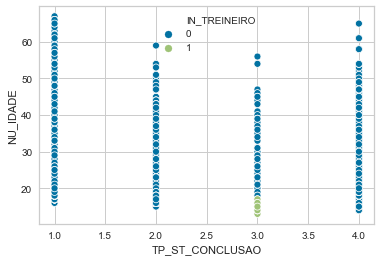

In [6]:
sns.scatterplot(x=train.TP_ST_CONCLUSAO,y=train.NU_IDADE,hue=train.IN_TREINEIRO)

### Aparentemente os dados de treino estão desbalanceados, vamos fazer uma avaliação das proporções

In [12]:
train.IN_TREINEIRO.value_counts()
print(f"Porcentagem 0: {train.IN_TREINEIRO.value_counts()[0]/train.IN_TREINEIRO.shape[0]}")
print(f"Porcentagem 0: {train.IN_TREINEIRO.value_counts()[1]/train.IN_TREINEIRO.shape[0]}")

Porcentagem 0: 0.8701383831026949
Porcentagem 0: 0.12986161689730516


### Vamos utilizar um modelo de resampling para rebalancear os dados

In [11]:
#teste feature selection 1
feature_target_model01 = extract_target_feature(train,['NU_IDADE','TP_ST_CONCLUSAO','IN_TREINEIRO'])

In [25]:
smote  = SMOTE(sampling_strategy='minority',random_state=7)
t = smote.fit_sample(feature_target_model01[0],feature_target_model01[1])

Rodaremos o modelo utilizando somente as duas variáveis acima para para avaliar a precisão.

In [26]:
ft1_train,ft1_test,tg1_train,tg1_test = train_test_split(t[0],t[1],test_size=0.30,random_state=42)

In [27]:
tg1_train

array([1, 1, 1, ..., 0, 1, 1])

In [28]:
#Logistic Regression
logistic = LogisticRegression()
logistic.fit(ft1_train,tg1_train)

LogisticRegression()

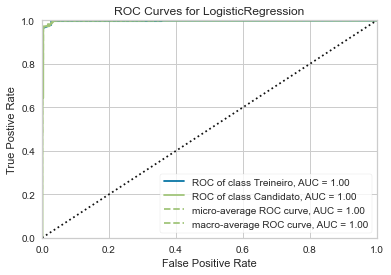

In [29]:
visualizer = ROCAUC(logistic,classes=['Treineiro','Candidato'])
visualizer.fit(ft1_train,tg1_train)
visualizer.score(ft1_test,tg1_test)
visualizer.show()

In [31]:
logistic.score(ft1_test,tg1_test)

0.9828427953689497

In [32]:
def submit_codenation(model,features,df_test,id):
    features = df_test[features]
    predicted = model.predict(features)
    df_test['IN_TREINEIRO'] = predicted
    df_return = df_test[[id,'IN_TREINEIRO']]
    return df_return


In [33]:
df_test = pd.read_csv('test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4570 entries, 0 to 4569
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NU_INSCRICAO            4570 non-null   object 
 1   CO_UF_RESIDENCIA        4570 non-null   int64  
 2   SG_UF_RESIDENCIA        4570 non-null   object 
 3   NU_IDADE                4570 non-null   int64  
 4   TP_SEXO                 4570 non-null   object 
 5   TP_COR_RACA             4570 non-null   int64  
 6   TP_NACIONALIDADE        4570 non-null   int64  
 7   TP_ST_CONCLUSAO         4570 non-null   int64  
 8   TP_ANO_CONCLUIU         4570 non-null   int64  
 9   TP_ESCOLA               4570 non-null   int64  
 10  TP_ENSINO               1426 non-null   float64
 11  TP_DEPENDENCIA_ADM_ESC  1426 non-null   float64
 12  IN_BAIXA_VISAO          4570 non-null   int64  
 13  IN_CEGUEIRA             4570 non-null   int64  
 14  IN_SURDEZ               4570 non-null   

In [30]:
answer = submit_codenation(logistic,['NU_IDADE','TP_ST_CONCLUSAO'],df_test,'NU_INSCRICAO')
answer.to_csv('answer.csv',index=False)